In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import joblib

original_df = pd.read_csv('Data/diabetes_012_health_indicators_BRFSS2015.csv')

y = original_df.Diabetes_012
X = original_df.drop('Diabetes_012', axis=1)

In [2]:
# because RandomUnderSampler works best with numeric input.  let’s convert the categorical columns first

# Numerical Predictors
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
# numerical_cols = list(dict.fromkeys(numerical_cols))  # Remove duplicates just in case

# Categorical Predictors
categorical_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income'
]

# One-hot encode categorical features and drop the first category of each
# Feature Engineering - Turns categorical data into a numerical format that a model can understand
X_cat = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Extract the numerical features
X_num = X[numerical_cols]

# Concatenate numerical and encoded categorical features
X = pd.concat([X_num, X_cat], axis=1)

# Remove any duplicated columns that may result from concat
X = X.loc[:, ~X.columns.duplicated()]

print("Encoded feature shape:", X.shape)
print("Original class distribution:", Counter(y))

Encoded feature shape: (253680, 34)
Original class distribution: Counter({0.0: 213703, 2.0: 35346, 1.0: 4631})


In [3]:
# Define strategy: target number of samples per class
undersample_strategy = {0.0: 25000, 1.0: 4631, 2.0: 35346}

# Initialize undersampler
rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Apply undersampling
X_balanced, y_balanced = rus.fit_resample(X, y)

# Check new class distribution
print("New class distribution:", Counter(y_balanced))
print("Balanced feature shape:", X_balanced.shape)

New class distribution: Counter({2.0: 35346, 0.0: 25000, 1.0: 4631})
Balanced feature shape: (64977, 34)


In [4]:
# Uses the balanced data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# Scaler will only fit on training data so, calculates Mean & STD and stores this on the scaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Uses scaler that has only seen the traning data -> standardize

# Combine transformed training group +  assigned clean, matching row indices
df_train = pd.concat(
    [X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1
)


In [5]:
# Removing 'MentHlth' from being an outlier as a single unique value is being treated as an outlier but, is a valid data point
numerical_cols2 = ['BMI', 'Age']

# Set a z-score threshold: ±1 SD → ~68.3% of data, ±2 SD → ~95.5% of data, ±3 SD → ~99.7% of data
threshold = 3    

# Calculate absolute z-scores for numerical columns
z_scores = np.abs(df_train[numerical_cols2])

# Mask: rows where any numerical feature has a z-score >= threshold of 3
outlier_mask = (z_scores >= threshold).any(axis=1)

# Get the outlier rows
outliers = df_train[outlier_mask]

# Get the cleaned training data (rows that are NOT outliers)
df_train_cleaned = df_train[~outlier_mask].reset_index(drop=True)

# Show the outliers
# print("Outlier rows removed from training data:")
# print(outliers)

# Print how many were removed
print(f"\nRemoved {len(outliers)} outliers from training data.")


Removed 613 outliers from training data.


In [6]:
print("Numerical columns after original scaling (before outlier removal):")
print(X_train[numerical_cols].describe())

z_scores = np.abs(df_train[numerical_cols2])  # these are scaled already
outlier_mask = (z_scores >= 3).any(axis=1)
df_train_cleaned = df_train[~outlier_mask].reset_index(drop=True)

# Recreate X_train and y_train from cleaned DataFrame
X_train = df_train_cleaned.drop('Diabetes_012', axis=1)
y_train = df_train_cleaned['Diabetes_012']

# Refit scaler on cleaned training data
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Apply to test set
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nNumerical columns after rescaling cleaned training data:")
print(X_train[numerical_cols].describe())


Numerical columns after original scaling (before outlier removal):
                BMI      MentHlth      PhysHlth           Age
count  5.198100e+04  5.198100e+04  5.198100e+04  5.198100e+04
mean  -2.836375e-17  2.610832e-17 -2.460470e-17  1.924634e-16
std    1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00
min   -2.545021e+00 -4.688812e-01 -6.005857e-01 -2.787637e+00
25%   -5.873680e-01 -4.688812e-01 -6.005857e-01 -6.293767e-01
50%   -1.678709e-01 -4.688812e-01 -6.005857e-01  9.004343e-02
75%    5.312908e-01 -1.096495e-01  7.595034e-02  8.094635e-01
max    9.480561e+00  3.123436e+00  2.298855e+00  1.528884e+00

Numerical columns after rescaling cleaned training data:
                BMI      MentHlth      PhysHlth           Age
count  5.136800e+04  5.136800e+04  5.136800e+04  5.136800e+04
mean   1.155005e-17 -5.747362e-17 -1.410905e-17  2.960134e-17
std    1.000010e+00  1.000010e+00  1.000010e+00  1.000010e+00
min   -2.842776e+00 -4.659470e-01 -5.957418e-01 -2.792207e+00
25%   -

In [ ]:
from sklearn.svm import SVC
# SVC linear

# Test different tuning for SVC
C_values = [0.5, 0.75, 1, 1.5]
gamma_values = ['scale', 0.05, 0.1, 1]

results = {}

for C in C_values:
    clf = SVC(kernel='linear', C=C, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    key = f"SVM_Linear_C={C}"
    results[key] = classification_report(y_test, y_pred, output_dict=True)
    print(f"\n--- Classification Report: {key} ---")
    print(classification_report(y_test, y_pred))

In [16]:
# SVC with rbf kernel

for C in C_values:
    for gamma in gamma_values:
        clf = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        key = f"SVM_RBF_C={C}_gamma={gamma}"
        results[key] = classification_report(y_test, y_pred, output_dict=True)
        print(f"\n--- Classification Report: {key} ---")
        print(classification_report(y_test, y_pred))



--- Classification Report: SVM_RBF_C=0.5_gamma=scale ---
              precision    recall  f1-score   support

         0.0       0.72      0.62      0.66      5000
         1.0       0.10      0.33      0.16       926
         2.0       0.76      0.62      0.68      7070

    accuracy                           0.60     12996
   macro avg       0.53      0.52      0.50     12996
weighted avg       0.70      0.60      0.64     12996


--- Classification Report: SVM_RBF_C=0.5_gamma=0.05 ---
              precision    recall  f1-score   support

         0.0       0.73      0.60      0.66      5000
         1.0       0.11      0.35      0.16       926
         2.0       0.76      0.62      0.69      7070

    accuracy                           0.60     12996
   macro avg       0.53      0.53      0.50     12996
weighted avg       0.70      0.60      0.64     12996


--- Classification Report: SVM_RBF_C=0.5_gamma=0.1 ---
              precision    recall  f1-score   support

         0.0

In [17]:
# One-vs-Rest Logistic Regression (L1)

for C in C_values:
    clf = OneVsRestClassifier(
        # saga solver is required for L1 penalty
        LogisticRegression(penalty='l1', solver='saga', C=C, class_weight='balanced', max_iter=1000)
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    key = f"OVR_LogReg_L1_C={C}"
    results[key] = classification_report(y_test, y_pred, output_dict=True)
    print(f"\n--- Classification Report: {key} ---")
    print(classification_report(y_test, y_pred))



--- Classification Report: OVR_LogReg_L1_C=0.5 ---
              precision    recall  f1-score   support

         0.0       0.66      0.69      0.68      5000
         1.0       0.11      0.13      0.12       926
         2.0       0.75      0.71      0.73      7070

    accuracy                           0.66     12996
   macro avg       0.51      0.51      0.51     12996
weighted avg       0.67      0.66      0.67     12996


--- Classification Report: OVR_LogReg_L1_C=0.75 ---
              precision    recall  f1-score   support

         0.0       0.66      0.69      0.68      5000
         1.0       0.11      0.13      0.12       926
         2.0       0.75      0.71      0.73      7070

    accuracy                           0.66     12996
   macro avg       0.51      0.51      0.51     12996
weighted avg       0.67      0.66      0.67     12996


--- Classification Report: OVR_LogReg_L1_C=1 ---
              precision    recall  f1-score   support

         0.0       0.66     

In [9]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
# Test different tuning for SVC
# C_values = [1.0, 5, 10]

results = {}

# Make sure to set probability=True when using SVC
clf = OneVsRestClassifier(
    LogisticRegression(penalty='l1', solver='saga', C=1.0, class_weight='balanced', max_iter=1000)
)
clf.fit(X_train, y_train)

# Get probabilities for each class
y_proba = clf.predict_proba(X_test)

In [13]:
# Default threshold is 0.5
thresholds = [0.2, 0.3, 0.4, 0.5]

for thresh in thresholds:
    y_pred_custom = []
    for probs in y_proba:
        if probs[2] >= thresh:
            y_pred_custom.append(2)
        else:
            # Pick the higher of class 0 or 1 if class 2 isn't confident enough
            y_pred_custom.append(np.argmax(probs[:2]))
    
    print(f"\n--- Classification Report for Class 2 Threshold = {thresh} ---")
    print(classification_report(y_test, y_pred_custom))



--- Classification Report for Class 2 Threshold = 0.2 ---
              precision    recall  f1-score   support

         0.0       0.80      0.51      0.62      5000
         1.0       0.00      0.00      0.00       926
         2.0       0.67      0.93      0.78      7070

    accuracy                           0.70     12996
   macro avg       0.49      0.48      0.47     12996
weighted avg       0.67      0.70      0.66     12996


--- Classification Report for Class 2 Threshold = 0.3 ---
              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67      5000
         1.0       0.11      0.03      0.05       926
         2.0       0.72      0.81      0.76      7070

    accuracy                           0.70     12996
   macro avg       0.51      0.50      0.49     12996
weighted avg       0.66      0.70      0.68     12996


--- Classification Report for Class 2 Threshold = 0.4 ---
              precision    recall  f1-score   support

      

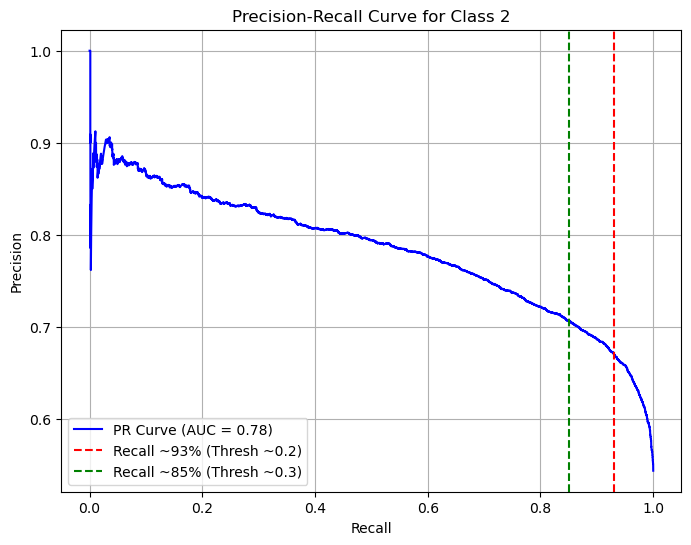

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Assume y_test and y_proba are already defined and available from previous steps

# Extract class 2 probabilities
y_test_binary_class2 = (y_test == 2).astype(int)
y_proba_class2 = [proba[2] for proba in y_proba]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_binary_class2, y_proba_class2)

# Compute AUC for PR curve
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', color='blue')
plt.axvline(x=0.93, linestyle='--', color='red', label='Recall ~93% (Thresh ~0.2)')
plt.axvline(x=0.85, linestyle='--', color='green', label='Recall ~85% (Thresh ~0.3)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 2')
plt.legend()
plt.grid(True)
plt.show()
